In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import pickle

In [2]:
# ---------- Helper Functions: box uncertainty set & weighting factor ----------

# 1. Construct the box-shaped uncertainty set Ξ (axis-aligned hyper-rectangle)
def build_box_uncertainty(Z_all, qmin=0.01, qmax=0.99, eta=0.02):
    """return [ell, upp] in each dimension of Z_all"""
    low  = np.quantile(Z_all, qmin, axis=0)
    high = np.quantile(Z_all, qmax, axis=0)
    span = high - low
    ell  = low  - eta * span
    upp  = high + eta * span
    # Avoid zero-width intervals
    upp = np.maximum(upp, ell + 1e-10)
    return ell, upp

def build_box_conic_from_bounds(ell, upp, n):
    """
    Rewrite the box uncertainty set  Ξ = { (x,y): ell <= (x,y) <= upp }
    into the form C1 x + c2 y <= d   (C is the nonnegative orthant cone), for direct use of Corollary 3.3.
    Return C1 (m*n), c2 (m,), d (m,), where m = 2*(n+1)
    where n = dim(x), y is a scalar
    """
    m = 2*(n+1)
    C1 = np.zeros((m, n))
    c2 = np.zeros(m)
    d  = np.zeros(m)

    row = 0
    # upper bound： x_j <= upp_j
    for j in range(n):
        C1[row, j] = 1.0
        d[row] = upp[j]
        row += 1
    # lower bound： -x_j <= -ell_j
    for j in range(n):
        C1[row, j] = -1.0
        d[row] = -ell[j]
        row += 1
    # upper bound for y： y <= upp_y
    c2[row] = 1.0
    d[row] = upp[n]
    row += 1
    # lower bound for y： -y <= -ell_y
    c2[row] = -1.0
    d[row] = -ell[n]
    row += 1

    assert row == m
    return C1, c2, d

# 2a. Compute time-dependent sample weights (exponential forgetting)
def time_weights_from_indices(time_idx, now_t, decay):
    raw = decay ** (now_t - time_idx)
    pi = raw / raw.sum()
    return pi

# 2b. Optimal weights according to Proposition 2 (for p = 1)
def optimal_weights_prop2(T, eps_over_rho):
    """
    Proposition 2 optimal weights for p = 1:
    - T = history length
    - eps_over_rho = ε/ρ in the paper, where eps in our code is ambuiguity radius, rho is the wasserstein distance between Pt and Pt+1
    Return weights w of length T
    """

    # s = floor(eps / rho)
    s = int(np.floor(eps_over_rho))
    s = max(1, min(s, T))  # truncate to [1, T]
    
    w = np.zeros(T)
    denom = s * (2 * eps_over_rho - s - 1)
    
    for t in range(T - s, T):
        # t runs from T-s to T-1  (0-index)
        w[t] = 2 * ((eps_over_rho) + (t+1) - T - 1) / denom

    return w

# 3. DRO ε-insensitive SVR
# ---------- Core：DRO-SVR following Corollary 3.3 ----------
def solve_dro_svr_cor33(X, y, C1, c2, d, pi, epsilon=60000.0, rho=0.5, use_mosek=True):
    """
    Corollary 3.3 (Support Vector Regression):
      min   λ ρ + sum_i π_i s_i
      s.t.  y_i - <w,x_i> - ε + <p_i^+, d - C1 x_i - c2 y_i> <= s_i
            <w,x_i> - y_i - ε + <p_i^-, d - C1 x_i - c2 y_i> <= s_i
            || ( C1^T p_i^+ + w ,  c2^T p_i^+ - 1 ) ||_* <= λ
            || ( C1^T p_i^- - w ,  c2^T p_i^- + 1 ) ||_* <= λ
            p_i^+, p_i^- >= 0,  s_i >= 0
    """
    N, n = X.shape
    m = C1.shape[0]  # number of constraints (2*(n+1))

    w   = cp.Variable(n)
    lam = cp.Variable(nonneg=True)
    s   = cp.Variable(N, nonneg=True)

    constraints = []

    # pre-calculate (d - C1 x_i - c2 y_i) for each sample
    D_minus_Axi_cy = (d[None, :] - X @ C1.T - np.outer(y, c2))  # (N,m)

    for i in range(N):
        p_plus_i  = cp.Variable(m, nonneg=True)
        p_minus_i = cp.Variable(m, nonneg=True)

        # y_i - <w,x_i> - ε + <p_i^+, ...> <= s_i
        lhs1_i = (y[i] - X[i] @ w - epsilon + p_plus_i @ D_minus_Axi_cy[i, :])
        constraints += [lhs1_i <= s[i]]

        # <w,x_i> - y_i - ε + <p_i^-, ...> <= s_i
        lhs2_i = (X[i] @ w - y[i] - epsilon + p_minus_i @ D_minus_Axi_cy[i, :])
        constraints += [lhs2_i <= s[i]]

        # || ( C1^T p_i^+ + w ,  c2^T p_i^+ - 1 ) ||_2 <= λ
        # || ( C1^T p_i^- - w ,  c2^T p_i^- + 1 ) ||_2 <= λ
        vec_minus = cp.hstack([C1.T @ p_minus_i - w,  c2 @ p_minus_i + 1.0])
        vec_plus = cp.hstack([C1.T @ p_plus_i + w,  c2 @ p_plus_i - 1.0])

        constraints += [
            cp.norm(vec_plus,  'inf') <= lam,
            cp.norm(vec_minus, 'inf') <= lam
        ]

    # objective：λ ρ + sum_i π_i s_i
    pi_param = cp.Parameter(N, nonneg=True, value=np.asarray(pi, float))
    obj = cp.Minimize(lam * rho + pi_param @ s)

    prob = cp.Problem(obj, constraints)
    try:
        prob.solve(solver=cp.MOSEK if use_mosek else cp.ECOS, verbose=False)
    except cp.SolverError:
        prob.solve(solver=cp.ECOS, verbose=False)

    return w.value, prob.status

# 4. Empirical ε-insensitive SVR (no regularization, time-weighted)
def solve_empirical_svr_noreg(X, y, epsilon=60000.0, sample_weights=None, use_mosek=True):
    N, n = X.shape
    w = cp.Variable(n)
    resid = y - X @ w
    loss  = cp.pos(cp.abs(resid) - epsilon)  # max(0, |r|-ε)

    if sample_weights is None:
        obj = cp.Minimize(cp.sum(loss) / N)
    else:
        sw = cp.Parameter(N, nonneg=True, value=np.asarray(sample_weights, float))
        weighted_loss = cp.sum(cp.multiply(sw, loss))
        obj = cp.Minimize(weighted_loss)

    prob = cp.Problem(obj)
    try:
        prob.solve(solver=cp.MOSEK if use_mosek else cp.ECOS, verbose=False)
    except cp.SolverError:
        prob.solve(solver=cp.ECOS, verbose=False)
    return w.value, prob.status

# 5. ε-insensitive loss
def eps_ins_loss(y_true, y_pred, eps):
    return np.maximum(0, np.abs(y_true - y_pred) - eps)

In [3]:
def generate_data_stream(rng, T, drift_scale_mu, drift_scale_cov, drift_scale_w, SAMPLES_PER_T):
    """Generate evolving (X,y) data stream and drifted parameters."""
    number_dimension = 5
    sigma_eps = 8000.0

    # initial setup
    mu_x = np.array([rng.uniform(80, 120),
                     rng.uniform(3, 6),
                     rng.uniform(20, 50),
                     rng.uniform(2, 8),
                     rng.uniform(0.4, 0.8)])
    A = rng.normal(0, 1, size=(number_dimension, number_dimension))
    Sigma_x = A @ A.T + np.diag([30, 1, 15, 2, 0.1])
    w_true = np.array([600, 5000, -200, -1000, 15000])

    mu_history = [mu_x.copy()]
    Sigma_history = [Sigma_x.copy()]
    w_history = [w_true.copy()]
    data_stream = []

    for t in range(T):
        mu_t = mu_history[-1]
        Sigma_t = Sigma_history[-1]
        w_t = w_history[-1]

        mu_y = float(mu_t @ w_t)
        Sigma_xy = Sigma_t @ w_t
        Sigma_yy = float(w_t.T @ Sigma_t @ w_t + sigma_eps**2)
        mu_joint = np.hstack([mu_t, mu_y])
        Sigma_joint = np.block([
            [Sigma_t, Sigma_xy.reshape(-1, 1)],
            [Sigma_xy.reshape(1, -1), np.array([[Sigma_yy]])]
        ])

        Z = rng.multivariate_normal(mu_joint, Sigma_joint, size=SAMPLES_PER_T)
        data_stream.append(Z)

        # drift next
        drift_mu = drift_scale_mu * np.abs(mu_t)
        drift_w = drift_scale_w * np.abs(w_t)
        mu_next = mu_t + rng.uniform(-drift_mu, drift_mu, size=mu_t.shape)
        Sigma_next = Sigma_t + drift_scale_cov * rng.normal(0, 1, size=Sigma_t.shape)
        Sigma_next = (Sigma_next + Sigma_next.T) / 2 + np.eye(number_dimension) * 1e-6
        w_next = w_t + rng.uniform(-drift_w, drift_w, size=w_t.shape)

        mu_history.append(mu_next)
        Sigma_history.append(Sigma_next)
        w_history.append(w_next)

    return data_stream, mu_history, Sigma_history, w_history

In [4]:
def single_simulation(rng, drift_scale_mu, drift_scale_cov, drift_scale_w, rho_list, decay_list, drift_bound_list, epsilon=8000.0, SAMPLES_PER_T=10):
    """
    single simulation:
      - generate T history samples and real future in t=T+1
      - consider different parameter combinations
      - return average expected loss for each parameter combination
    """
    T = 10
    data_stream, mu_hist, Sigma_hist, w_hist = generate_data_stream(rng, T, drift_scale_mu, drift_scale_cov, drift_scale_w, SAMPLES_PER_T)

    # training data: first 6 periods (flatten)
    Z_all = np.vstack(data_stream)
    X_all, y_all = Z_all[:, :-1], Z_all[:, -1]
    
    # ----------------------------------------
    # I. PRE-GENERATE the Test Scenarios (Drifts)
    # ----------------------------------------
    test_scenarios = []
    for _ in range(8):
        mu_next = mu_hist[-1] + rng.uniform(-drift_scale_mu * np.abs(mu_hist[-1]), drift_scale_mu * np.abs(mu_hist[-1]), size=mu_hist[-1].shape)
        Sigma_next = Sigma_hist[-1] + drift_scale_cov * rng.normal(0, 1, size=Sigma_hist[-1].shape)
        Sigma_next = (Sigma_next + Sigma_next.T) / 2 + np.eye(X_all.shape[1]) * 1e-6
        w_next = w_hist[-1] + rng.uniform(-drift_scale_w * np.abs(w_hist[-1]), drift_scale_w * np.abs(w_hist[-1]), size=w_hist[-1].shape)

        mu_y = float(mu_next @ w_next)
        Sigma_xy = Sigma_next @ w_next
        Sigma_yy = float(w_next.T @ Sigma_next @ w_next + 8000.0**2)
        mu_joint = np.hstack([mu_next, mu_y])
        Sigma_joint = np.block([
            [Sigma_next, Sigma_xy.reshape(-1, 1)],
            [Sigma_xy.reshape(1, -1), np.array([[Sigma_yy]])]
        ])

        Z7 = rng.multivariate_normal(mu_joint, Sigma_joint, size=SAMPLES_PER_T)
        X7, y7 = Z7[:, :-1], Z7[:, -1]
        test_scenarios.append((X7, y7))

    losses = {}

    # ----------------------------------------
    # II. Weighted dro SVR (Training)
    # ----------------------------------------
    for rho in rho_list:
        for decay in decay_list:
            # sample weights
            time_idx = np.repeat(np.arange(T), len(data_stream[0]))
            pi = time_weights_from_indices(time_idx, now_t=T-1, decay=decay)

            # DRO-SVR training
            ell, upp = build_box_uncertainty(Z_all, qmin=0.01, qmax=0.99, eta=0.02)
            C1, c2, d = build_box_conic_from_bounds(ell, upp, X_all.shape[1])
            w_hat, _ = solve_dro_svr_cor33(X_all, y_all, C1, c2, d, pi, epsilon=epsilon, rho=rho)

            loss_list = []
            for X7, y7 in test_scenarios:
                y_pred = X7 @ w_hat
                loss7 = eps_ins_loss(y7, y_pred, epsilon).mean()
                loss_list.append(loss7)
                
            losses[('dro_weighted', rho, decay)] = np.mean(loss_list)

    # ----------------------------------------
    # III. Weighted Empirical SVR (W-SAA)
    # ----------------------------------------
    for decay in decay_list:
        time_idx = np.repeat(np.arange(T), len(data_stream[0]))
        pi = time_weights_from_indices(time_idx, now_t=T-1, decay=decay)
        
        # Training
        w_hat_emp_w, _ = solve_empirical_svr_noreg(X_all, y_all, epsilon=epsilon, sample_weights=pi)

        # Testing
        loss_list = []
        for X7, y7 in test_scenarios:
            y_pred = X7 @ w_hat_emp_w
            loss7 = eps_ins_loss(y7, y_pred, epsilon).mean()
            loss_list.append(loss7)
        
        losses[('empirical_weighted', 0.0, decay)] = np.mean(loss_list)

    # ----------------------------------------
    # IV. Unweighted Empirical SVR (SAA)
    # ----------------------------------------
    w_hat_emp_unw, _ = solve_empirical_svr_noreg(X_all, y_all, epsilon=epsilon, sample_weights=None)
    loss_list = []
    for X7, y7 in test_scenarios:
        y_pred = X7 @ w_hat_emp_unw
        loss7 = eps_ins_loss(y7, y_pred, epsilon).mean()
        loss_list.append(loss7)
        
    losses[('empirical_unweighted', 0.0, 0.0)] = np.mean(loss_list)

    # ----------------------------------------
    # V. Optimal weights from Prop2
    # ----------------------------------------
    # choose eps_over_rho range
    for rho in rho_list:
        for drift_bound in drift_bound_list:
            eps_over_rho = rho / drift_bound
            pi_time = optimal_weights_prop2(T, eps_over_rho)
            pi_samples = np.repeat(pi_time, len(data_stream[0]))
            pi_samples = pi_samples / pi_samples.sum()

            # DRO-SVR training
            ell, upp = build_box_uncertainty(Z_all, qmin=0.01, qmax=0.99, eta=0.02)
            C1, c2, d = build_box_conic_from_bounds(ell, upp, X_all.shape[1])
            w_hat, _ = solve_dro_svr_cor33(X_all, y_all, C1, c2, d, pi_samples, epsilon=epsilon, rho=rho)

            loss_list = []
            for X7, y7 in test_scenarios:
                y_pred = X7 @ w_hat
                loss7 = eps_ins_loss(y7, y_pred, epsilon).mean()
                loss_list.append(loss7)
                
            losses[('dro_optimal_weighted', rho, drift_bound)] = np.mean(loss_list)

    return losses # Return all calculated losses

In [5]:
def run_multiple_simulations(num_runs=5, drift_scale_mu=None, drift_scale_cov=0.02, drift_scale_w=0.025,
                             rho_list=None, decay_list=None, drift_bound_list=None, epsilon=8000.0, SAMPLES_PER_T=10):
    base_rng = np.random.default_rng(seed=42)
    
    dro_losses = []
    emp_weighted_losses = []
    emp_unweighted_losses = []
    prop2_losses = []

    for run in range(num_runs):
        print(f"Simulation {run+1}/{num_runs}")
        rng = np.random.default_rng(base_rng.integers(1e9)) 
        
        # results now contains all ('method', rho, decay) keys
        results = single_simulation(rng, drift_scale_mu, drift_scale_cov, drift_scale_w, rho_list, decay_list, drift_bound_list, epsilon=epsilon, SAMPLES_PER_T=SAMPLES_PER_T)

        # 1. DRO-SVR: find ex-post optimal (rho, decay) among DRO results
        dro_results = {k: v for k, v in results.items() if k[0] == 'dro_weighted'} 
        best_dro_param = min(dro_results, key=dro_results.get) 
        best_dro_loss = dro_results[best_dro_param]
        dro_losses.append(best_dro_loss)
        print(f"  → DRO-SVR Best param: ρ={best_dro_param[1]}, decay={best_dro_param[2]}, loss={best_dro_loss:.2f}")

        # 2. Weighted Empirical SVR (W-SAA): find ex-post optimal decay
        emp_w_results = {k: v for k, v in results.items() if k[0] == 'empirical_weighted'}
        best_emp_w_param = min(emp_w_results, key=emp_w_results.get)
        best_emp_w_loss = emp_w_results[best_emp_w_param]
        emp_weighted_losses.append(best_emp_w_loss)
        print(f"  → W-SAA Best param: decay={best_emp_w_param[2]}, loss={best_emp_w_loss:.2f}")
        
        # 3. Unweighted Empirical SVR (Unweighted SAA)
        unw_loss = results[('empirical_unweighted', 0.0, 0.0)]
        emp_unweighted_losses.append(unw_loss)
        print(f"  → Unweighted SAA loss: {unw_loss:.2f}")

        # 4. Optimal Weights from Prop2
        prop2_results = {k: v for k, v in results.items() if k[0] == 'dro_optimal_weighted'}
        best_prop2_param = min(prop2_results, key=prop2_results.get)
        best_prop2_loss = prop2_results[best_prop2_param]
        prop2_losses.append(best_prop2_loss)
        print(f"  → Prop2 Best param: ρ={best_prop2_param[1]}, drift_bound={best_prop2_param[2]}, loss={best_prop2_loss:.2f}")

    return {
        'DRO-SVR': np.array(dro_losses),
        'W-SAA': np.array(emp_weighted_losses),
        'SAA': np.array(emp_unweighted_losses),
        'Prop2': np.array(prop2_losses)
    }

In [6]:
rho_list = [0.05, 0.1, 0.5, 1.0]
decay_list = [0.65, 0.75, 0.85, 0.95]
drift_bound_list = [0.001, 0.02, 0.04]
drift_param_list = np.logspace(-3, -0.1, num=10)

avg_results_all_methods = {'DRO-SVR': {}, 'W-SAA': {}, 'SAA': {}, 'Prop2': {}}
sem_results_all_methods = {'DRO-SVR': {}, 'W-SAA': {}, 'SAA': {}, 'Prop2': {}}

for dp in drift_param_list:
    print(f"\nRunning simulations for drift parameter {dp:.1e}...")

    losses_all = run_multiple_simulations(
        num_runs=10,
        drift_scale_mu=dp,
        drift_scale_cov=dp,
        drift_scale_w=dp,
        rho_list=rho_list,
        decay_list=decay_list,
        drift_bound_list=drift_bound_list,
        epsilon=8000.0,
        SAMPLES_PER_T=20
    )

    dro_losses = np.array(losses_all['DRO-SVR'])
    w_saa_losses = np.array(losses_all['W-SAA'])
    saa_losses = np.array(losses_all['SAA'])
    prop2_losses = np.array(losses_all['Prop2'])

    n = len(dro_losses)
    baseline_mean = w_saa_losses.mean()

    dro_rel = dro_losses / baseline_mean
    w_saa_rel = w_saa_losses / baseline_mean
    saa_rel = saa_losses / baseline_mean
    prop2_rel = prop2_losses / baseline_mean

    avg_results_all_methods['DRO-SVR'][dp] = dro_rel.mean()
    sem_results_all_methods['DRO-SVR'][dp] = dro_rel.std(ddof=1) / np.sqrt(n)

    avg_results_all_methods['W-SAA'][dp] = w_saa_rel.mean()
    sem_results_all_methods['W-SAA'][dp] = w_saa_rel.std(ddof=1) / np.sqrt(n)

    avg_results_all_methods['SAA'][dp] = saa_rel.mean()
    sem_results_all_methods['SAA'][dp] = saa_rel.std(ddof=1) / np.sqrt(n)

    avg_results_all_methods['Prop2'][dp] = prop2_rel.mean()
    sem_results_all_methods['Prop2'][dp] = prop2_rel.std(ddof=1) / np.sqrt(n)

    print(
        f"Drift={dp:.1e} | "
        f"DRO mean={dro_rel.mean():.3f}±{dro_rel.std(ddof=1)/np.sqrt(n):.3f}, "
        f"W-SAA mean={w_saa_rel.mean():.3f}±{w_saa_rel.std(ddof=1)/np.sqrt(n):.3f}, "
        f"SAA mean={saa_rel.mean():.3f}±{saa_rel.std(ddof=1)/np.sqrt(n):.3f}, "
        f"Prop2 mean={prop2_rel.mean():.3f}±{prop2_rel.std(ddof=1)/np.sqrt(n):.3f}"
    )

# save results
with open("simulation_results_1order_withoptimalweights.pkl", "wb") as f:
    pickle.dump({
        "avg": avg_results_all_methods,
        "sem": sem_results_all_methods,
        "drift_list": drift_param_list,
    }, f)


Running simulations for drift parameter 1.0e-03...
Simulation 1/10
  → DRO-SVR Best param: ρ=0.1, decay=0.95, loss=1435.13
  → W-SAA Best param: decay=0.95, loss=1396.75
  → Unweighted SAA loss: 1393.04
  → Prop2 Best param: ρ=0.05, drift_bound=0.001, loss=1433.93
Simulation 2/10
  → DRO-SVR Best param: ρ=0.05, decay=0.65, loss=1660.90
  → W-SAA Best param: decay=0.95, loss=1674.45
  → Unweighted SAA loss: 1657.59
  → Prop2 Best param: ρ=0.05, drift_bound=0.001, loss=1691.89
Simulation 3/10
  → DRO-SVR Best param: ρ=0.1, decay=0.75, loss=1938.01
  → W-SAA Best param: decay=0.65, loss=2079.27
  → Unweighted SAA loss: 2121.08
  → Prop2 Best param: ρ=0.1, drift_bound=0.04, loss=1898.62
Simulation 4/10
  → DRO-SVR Best param: ρ=0.1, decay=0.95, loss=1163.85
  → W-SAA Best param: decay=0.95, loss=1252.35
  → Unweighted SAA loss: 1209.03
  → Prop2 Best param: ρ=0.1, drift_bound=0.001, loss=1157.72
Simulation 5/10
  → DRO-SVR Best param: ρ=0.05, decay=0.75, loss=1535.61
  → W-SAA Best param:

C:\Users\11864\AppData\Local\Temp\ipykernel_35024\3645949456.py:34: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Z7 = rng.multivariate_normal(mu_joint, Sigma_joint, size=SAMPLES_PER_T)


  → DRO-SVR Best param: ρ=0.05, decay=0.65, loss=1509.47
  → W-SAA Best param: decay=0.65, loss=1468.32
  → Unweighted SAA loss: 1483.83
  → Prop2 Best param: ρ=0.05, drift_bound=0.001, loss=1563.38
Simulation 6/10
  → DRO-SVR Best param: ρ=0.05, decay=0.85, loss=1546.44
  → W-SAA Best param: decay=0.95, loss=1490.72
  → Unweighted SAA loss: 1472.67
  → Prop2 Best param: ρ=0.05, drift_bound=0.001, loss=1590.32
Simulation 7/10
  → DRO-SVR Best param: ρ=0.05, decay=0.95, loss=1347.26
  → W-SAA Best param: decay=0.85, loss=1431.47
  → Unweighted SAA loss: 1430.91
  → Prop2 Best param: ρ=0.05, drift_bound=0.001, loss=1347.26
Simulation 8/10
  → DRO-SVR Best param: ρ=0.05, decay=0.95, loss=1441.15
  → W-SAA Best param: decay=0.95, loss=1377.44
  → Unweighted SAA loss: 1388.22
  → Prop2 Best param: ρ=0.05, drift_bound=0.001, loss=1440.70
Simulation 9/10
  → DRO-SVR Best param: ρ=0.05, decay=0.95, loss=1326.75
  → W-SAA Best param: decay=0.95, loss=1317.47
  → Unweighted SAA loss: 1335.50
  →

C:\Users\11864\AppData\Local\Temp\ipykernel_35024\805704945.py:35: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Z = rng.multivariate_normal(mu_joint, Sigma_joint, size=SAMPLES_PER_T)


  → DRO-SVR Best param: ρ=0.05, decay=0.85, loss=1358.51
  → W-SAA Best param: decay=0.85, loss=1346.71
  → Unweighted SAA loss: 1387.38
  → Prop2 Best param: ρ=0.05, drift_bound=0.001, loss=1376.22
Simulation 6/10
  → DRO-SVR Best param: ρ=0.05, decay=0.85, loss=1603.39
  → W-SAA Best param: decay=0.85, loss=1510.24
  → Unweighted SAA loss: 1523.19
  → Prop2 Best param: ρ=0.05, drift_bound=0.001, loss=1649.26
Simulation 7/10
  → DRO-SVR Best param: ρ=0.1, decay=0.75, loss=1413.46
  → W-SAA Best param: decay=0.85, loss=1467.08
  → Unweighted SAA loss: 1485.79
  → Prop2 Best param: ρ=0.1, drift_bound=0.001, loss=1393.68
Simulation 8/10
  → DRO-SVR Best param: ρ=0.05, decay=0.75, loss=1430.30
  → W-SAA Best param: decay=0.85, loss=1385.34
  → Unweighted SAA loss: 1391.81
  → Prop2 Best param: ρ=0.05, drift_bound=0.001, loss=1482.08
Simulation 9/10
  → DRO-SVR Best param: ρ=0.1, decay=0.95, loss=1376.77
  → W-SAA Best param: decay=0.95, loss=1356.69
  → Unweighted SAA loss: 1382.40
  → Pr

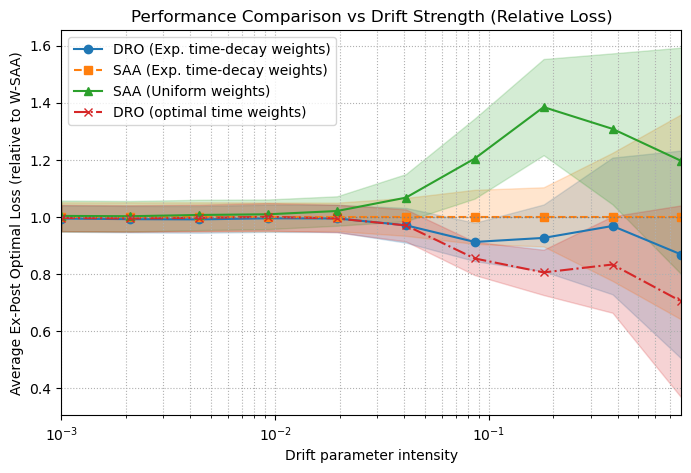

In [7]:
with open("simulation_results_1order_withoptimalweights.pkl", "rb") as f:
    data = pickle.load(f)

drift_params_array = np.array(list(avg_results_all_methods['DRO-SVR'].keys()))

dro_mean = np.array(list(avg_results_all_methods['DRO-SVR'].values()))
w_saa_mean = np.array(list(avg_results_all_methods['W-SAA'].values()))
saa_mean = np.array(list(avg_results_all_methods['SAA'].values()))
prop2_mean = np.array(list(avg_results_all_methods['Prop2'].values()))

dro_sem = np.array(list(sem_results_all_methods['DRO-SVR'].values()))
w_saa_sem = np.array(list(sem_results_all_methods['W-SAA'].values()))
saa_sem = np.array(list(sem_results_all_methods['SAA'].values()))
prop2_sem = np.array(list(sem_results_all_methods['Prop2'].values()))

plt.figure(figsize=(8,5))

# DRO-SVR
plt.plot(drift_params_array, dro_mean, marker='o', color='tab:blue', label='DRO (Exp. time-decay weights)')
plt.fill_between(drift_params_array, dro_mean - dro_sem, dro_mean + dro_sem,
                 color='tab:blue', alpha=0.2)

# W-SAA
plt.plot(drift_params_array, w_saa_mean, marker='s', linestyle='--',
         color='tab:orange', label='SAA (Exp. time-decay weights)')
plt.fill_between(drift_params_array, w_saa_mean - w_saa_sem, w_saa_mean + w_saa_sem,
                 color='tab:orange', alpha=0.2)

# SAA
plt.plot(drift_params_array, saa_mean, marker='^', color='tab:green', label='SAA (Uniform weights)')
plt.fill_between(drift_params_array, saa_mean - saa_sem, saa_mean + saa_sem,
                 color='tab:green', alpha=0.2)

# Prop2
plt.plot(drift_params_array, prop2_mean, marker='x', linestyle='-.',
         color='tab:red', label='DRO (optimal time weights)')
plt.fill_between(drift_params_array, prop2_mean - prop2_sem, prop2_mean + prop2_sem,
                 color='tab:red', alpha=0.2)

plt.axhline(y=1.0, color='gray', linestyle=':', linewidth=1)
plt.xscale('log')
plt.xlim(min(drift_params_array), max(drift_params_array))
plt.xlabel("Drift parameter intensity")
plt.ylabel("Average Ex-Post Optimal Loss (relative to W-SAA)")
plt.title("Performance Comparison vs Drift Strength (Relative Loss)")
plt.legend()
plt.grid(True, which='both', ls=':')
plt.show()